In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("hw10.ipynb")

# Spam/Ham Classification - Build Your Own Model
## Feature Engineering, Logistic Regression, Cross Validation


## This Model
Building and improving on the concepts and functions that I implemented in part 1 to create my own classifier to distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

In [3]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Setup and Recap

Here we will provide a summary of the homework 9 to remind you of how we cleaned the data, explored it, and implemented methods that are going to be useful for building your own model.

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading and Cleaning Data

Remember that in email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cell to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [5]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sat Apr 17 16:14:36 2021
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sat Apr 17 16:14:38 2021
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [6]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We therefore split the training data into separate training and validation datsets. You will need this **validation data** to assess the performance of your classifier once you are finished training. 

As in homework 9, we set the seed (random_state) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [7]:
# This creates a 90/10 train-validation split on our labeled data
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop=True)

### Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. To address this, in homework 9, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this homework, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

Run the following cell to see how the function works on some dummy text.

In [9]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

### EDA and Basic Classification

In homework 9, we proceeded to visualize the frequency of different words for both spam and ham emails, and used `words_in_texts(words, train['email'])` to directly to train a classifier. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `scikit-learn`.

Run the following cell to see the performance of a simple model using these words and the `train` dataframe.

In [10]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
training_accuracy = sum(Y_pred==Y_train)/len(Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


### Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. In homework 9, we calculated various metrics to lead us to consider more ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

# Moving Forward - Building Your Own Model

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on 70% of the test set when submitting to Gradescope, but we will be evaluating your model on the entire test set so try to score slightly above 88% on gradescope if you can.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much.

---

# My Own Model

In [14]:
train

,id,subject,email,spam
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0
...,...,...,...,...
7508,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0
7509,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale...",1
7510,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0
7511,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0


### 1. Split training data into spam emails `spam` and ham emails `ham`

In [13]:
spam=train[train['spam']==1]
ham=train[train['spam']==0]

### 2.Create and update a dictionary that keeps track of of how many times each

1) Use `Series.str.split()` to isolate the words


2) Create a custom function into `Series.apply` to update the dictionary each time it sees a word

In [15]:
spam=train[train['spam']==1]
ham=train[train['spam']==0]
spam_split=spam['email'].str.replace(r'[^0-9a-zA-Z]',' ').str.split()
ham_split = ham['email'].str.replace(r'[^0-9a-zA-Z]',' ').str.split()

In [16]:
spam_dict={}
ham_dict={}
def count_word_spam(lst):    
    for x in lst:
        if x not in spam_dict:
            spam_dict[x] = 1
        else:
            spam_dict[x] = spam_dict[x]+1

def count_word_ham(lst):    
    for x in lst:
        if x not in ham_dict:
            ham_dict[x] = 1
        else:
            ham_dict[x] = ham_dict[x]+1
            
spam_split.apply(count_word_spam) 
ham_split.apply(count_word_ham)

0       None
1       None
2       None
3       None
4       None
        ... 
7506    None
7508    None
7510    None
7511    None
7512    None
Name: email, Length: 5595, dtype: object

### 3.Create a list of the top 1000 words from each dictionary `top_1000_spam` and `top_1000_ham`


1) Use `sorted()` to sort the key and value according to the value in descending order for two dictionaries.

2) Use list comprehension to select the top 1000 words from the two dictionaries and store them in `top_1000_spam` and `top_1000_ham`.

In [17]:
sorted_spam_dict = sorted(spam_dict.items(), key=lambda x: x[1],reverse=True)
sorted_ham_dict = sorted(ham_dict.items(), key=lambda x: x[1],reverse=True)

sorted_spam_dict,sorted_ham_dict

top_1000_spam = [x[0] for x in sorted_spam_dict[:1000]]
top_1000_ham = [x[0] for x in sorted_ham_dict[:1000]]
top_1000_spam,top_1000_ham

(['3d',
  'font',
  'td',
  'the',
  'a',
  'to',
  'br',
  'size',
  'b',
  'and',
  'you',
  'tr',
  'of',
  'width',
  'face',
  'p',
  'color',
  'http',
  'nbsp',
  'com',
  'for',
  'your',
  'align',
  'in',
  '0',
  '1',
  '2',
  '20',
  'i',
  'this',
  'arial',
  'is',
  'center',
  'height',
  'www',
  'table',
  'border',
  'href',
  'that',
  'it',
  'or',
  'with',
  'be',
  'on',
  'verdana',
  'html',
  'helvetica',
  'name',
  'are',
  'style',
  '22',
  'we',
  'serif',
  'sans',
  'img',
  'div',
  's',
  'src',
  'from',
  'will',
  'bgcolor',
  'our',
  'email',
  '3',
  'have',
  'not',
  '3e',
  '5',
  'ffffff',
  'type',
  'text',
  '4',
  'free',
  'as',
  'if',
  'e',
  'content',
  'span',
  '000',
  'by',
  'us',
  'value',
  'all',
  'gif',
  '100',
  'can',
  'net',
  '000000',
  'option',
  'no',
  'body',
  'images',
  't',
  'mail',
  'here',
  'at',
  'click',
  'cellspacing',
  'more',
  'cellpadding',
  'li',
  'blockquote',
  'top',
  'do',
  'input

### 4.Find the words that are in `top_1000_spam` but not in `top_1000_ham`.

In [18]:
lst=[]
for x in top_1000_spam:
    if x in top_1000_ham:
        pass
    else:
        lst.append(x)

### 5.Training & Predicting

1) Call `words_in_texts` defined aboved on all the emails in the training set and the word list `lst` created in the previous step to create `x_train`, a matrix of 0s and 1s.

2) `y_train` is a vector of the correct labels for each email in the training set.
3) Use LogisticRegression model to fit in `x_train` and `y_train` and use it to predict on the training data.

In [19]:
#computing the training error
x_train=words_in_texts(lst, train['email'])
y_train= train['spam']

from sklearn.linear_model import LogisticRegression
my_model=LogisticRegression().fit(x_train,y_train)
y_pred = my_model.predict(x_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 6.Training accuracy

In [20]:
training_accuracy = sum(y_pred==y_train)/len(y_train)
training_accuracy

0.9723146545986956

### 7.Validation

In [21]:
from sklearn.model_selection import cross_val_score

validation_error=cross_val_score(my_model, words_in_texts(lst, val['email']), val['spam'], cv=5)
validation_error

array([0.90419162, 0.90419162, 0.90419162, 0.91616766, 0.92814371])

<!-- BEGIN QUESTION -->

### Question 1: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q1
manual: True
points: 6
-->

#### 1. How did you find better features for your model?


1) First, I splitted the training data into spam emails and ham emails. Then I created and update a dictionary that keeps track of how many times each word appears in spam emails and ham emails. Then I sorted out the top 1000 words from the two dictionaries and found the words that are in the top_spam but not in the top_ham. The result shall be my good features for my model.

2) Using visuliazation to see which features perform well. I tried to use different kinds plots to decide whether a feature is good enough to distinguish spam from ham email, such as bar plot, histogram, box plot, scatter plot and jitter plot.

3) Using the validation data to evaluate my model. I did a 5-fold cross_validation on X_train after splitting the training data into 80% as X_train and 20% as X_test. If the validation accuracy improved after adding certain feature, then it might be a good feature to use.

#### 2. What did you try that worked or didn't work?


At first, I tried searching for words in the train.csv but I couldn't find enough words that could distinguish spam and ham emails well.
Also, I plotted a box plot to see whether the number of capital letters in the subject of spam and ham emails is a good feature. However, although the spam emails have greater number of capital letters in their subjects, the difference is not significant.

#### 3. What was surprising in your search for good features?


The list `['3e','blockquote','3c', 'margin', 'ff0000', '2e', 'mso', 'a3', 'iiq', 'below', 'removed', 'bordercolor', 'nextpart','marketing', 'b5', '0pt', 'offer','3dcenter','credit','3cfont','2ffont', 'bb','0000ff','black','3darial', 'insurance','wish', '3d4', '000066', '81', '3b','a1',...]` contains top words from spam emails but not in ham emails.

From the top 32 words in the lst, I found that the combinations of letter characters and numbers are really common in spam emails, such as '3e','3c','ff0000','2e','a3','b5','0pt','3dcenter', etc.

<!-- END QUESTION -->



### Question 2: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q2
manual: True
format: image
points: 6
-->

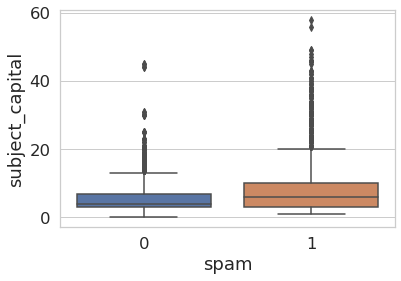

<Figure size 504x360 with 0 Axes>

In [23]:
# Write your description (2-3 sentences) as a comment here:
#This plot shows the number of capital letters in the subject of spam (1) and ham (0) emails.
#We can see that the spam emails have greater number of capital letters in their subjects.

# Write the code to generate your visualization here:
num_of_capital=train.subject.apply(lambda x: str(x)).str.findall("[A-Z]").apply(lambda x:len(x))
train["subject_capital"]=num_of_capital
sns.boxplot(x="spam",y="subject_capital",data=train)
plt.figure(figsize=(7,5))
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 20 or [Section 23.7](http://www.textbook.ds100.org/ch/23/classification_sensitivity_specificity.html?highlight=roc#roc-curves) of the course text to see how to plot an ROC curve.

<!--
BEGIN QUESTION
name: q3
manual: True
points: 3
-->

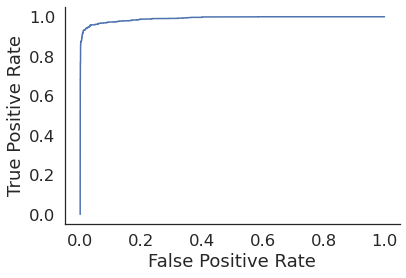

In [24]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

y_hat = my_model.predict_proba(x_train)[:,1]
y_hat

fpr, tpr, thresholds = roc_curve(y_train, y_hat)
with sns.axes_style("white"):
    plt.plot(fpr, tpr)

sns.despine()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

<!-- END QUESTION -->

# Question 4: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Homework 10 Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope. Your public Gradescope results are based off of your classifier's accuracy on 70% of the test dataset and your score for this question will be based off of your classifier's accuracy on 100% of the test set.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q4
points: 3
-->

In [25]:
test_predictions = my_model.predict(words_in_texts(lst, test['email']))

In [26]:
grader.check("q4")

q4 results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Homework 10 Test Predictions" assignment on Gradescope to get credit for this question.**

In [27]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2022-05-05T15:20:24.csv.
You may now upload this CSV file to Gradescope for scoring.


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [28]:
grader.check_all()

q4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()